## Imports

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as colors
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample

## Data Generation

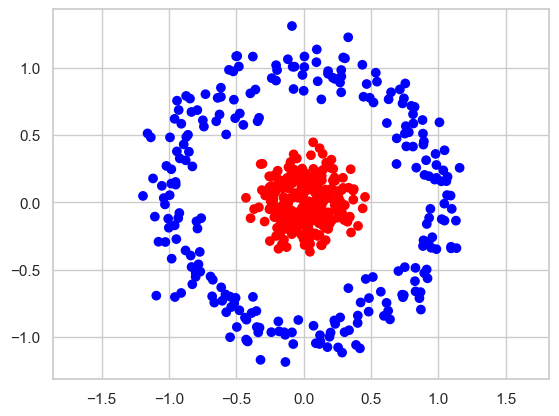

In [30]:
# Generate and visualize the dataset
X, y = make_circles(n_samples=500, noise=0.1, random_state=42, factor=0.2)
y = np.where(y == 0, -1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colors.ListedColormap(["blue", "red"]))
plt.axis('equal')
plt.show()

# Task 1

## Adaboost

In [31]:
class Adaboost:
    def __init__(self, model, n_clf=5):
        self.n_clf = n_clf
        self.model = model

    def fit(self, X, y):
        self.clfs = []
        self.clfs_alpha = []
        n_samples = X.shape[0]
        w = np.ones(n_samples) / n_samples

        for i in range(self.n_clf):
            clf = self.model()
            clf.fit(X, y, sample_weight=w)
            y_pred = clf.predict(X)
            err = np.sum(w * (y_pred != y)) / np.sum(w)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            w = w * np.exp(-alpha * y * y_pred)
            w /= np.sum(w)
            self.clfs.append(clf)
            self.clfs_alpha.append(alpha)
            self.plot_decision_boundary(X, y, i + 1)

    def predict(self, X):
        clf_preds = np.array([clf.predict(X) for clf in self.clfs])
        y_pred = np.sum(clf_preds.T * np.array(self.clfs_alpha), axis=1)
        return np.sign(y_pred)

    def plot_decision_boundary(self, X, y, iteration):
        if iteration == self.n_clf:
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                                np.arange(y_min, y_max, 0.01))

            fig, axes = plt.subplots(1, len(self.clfs) + 1, figsize=(5 * (len(self.clfs) + 1), 5))

            for i, clf in enumerate(self.clfs):
                Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
                Z = Z.reshape(xx.shape)
                axes[i].contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
                axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']))
                axes[i].set_title(f'Weak Learner {i + 1}')

            # Plot ensemble decision boundary
            Z = np.zeros(xx.ravel().shape)
            for clf, alpha in zip(self.clfs, self.clfs_alpha):
                Z += alpha * clf.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = np.sign(Z).reshape(xx.shape)
            axes[-1].contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
            axes[-1].scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']))
            axes[-1].set_title('Ensemble')

            plt.suptitle(f'Iteration {iteration}')
            plt.show()


## Performance on decision trees

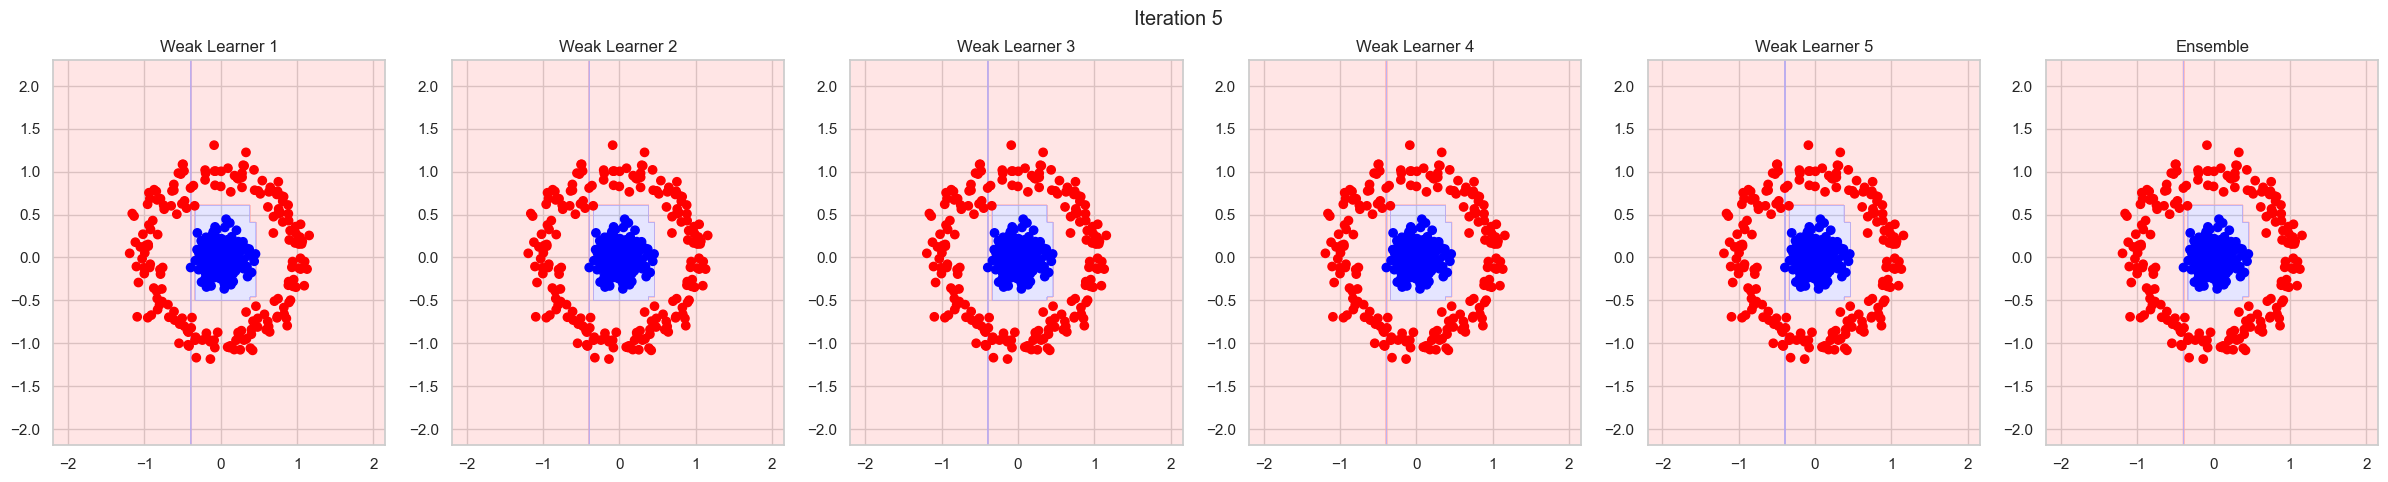

              precision    recall  f1-score   support

          -1       0.97      1.00      0.98        61
           1       1.00      0.97      0.98        64

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



In [32]:
ada = Adaboost(model=DecisionTreeClassifier, n_clf=5)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)
print(classification_report(y_test, y_pred))

# TASK 2

Training AdaBoost with Decision Tree as weak learner


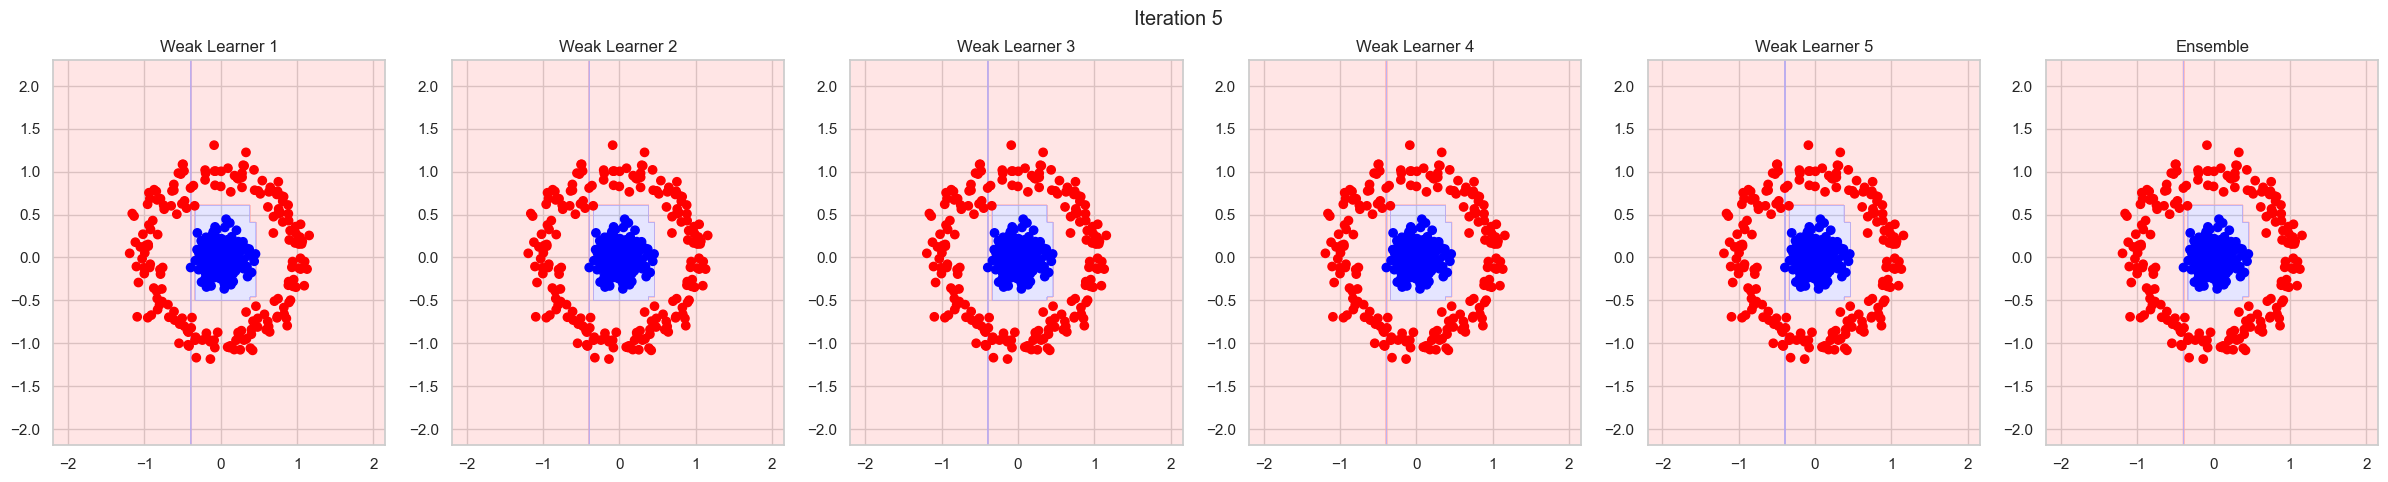

Accuracy: 0.98
Training AdaBoost with Logistic Regression as weak learner


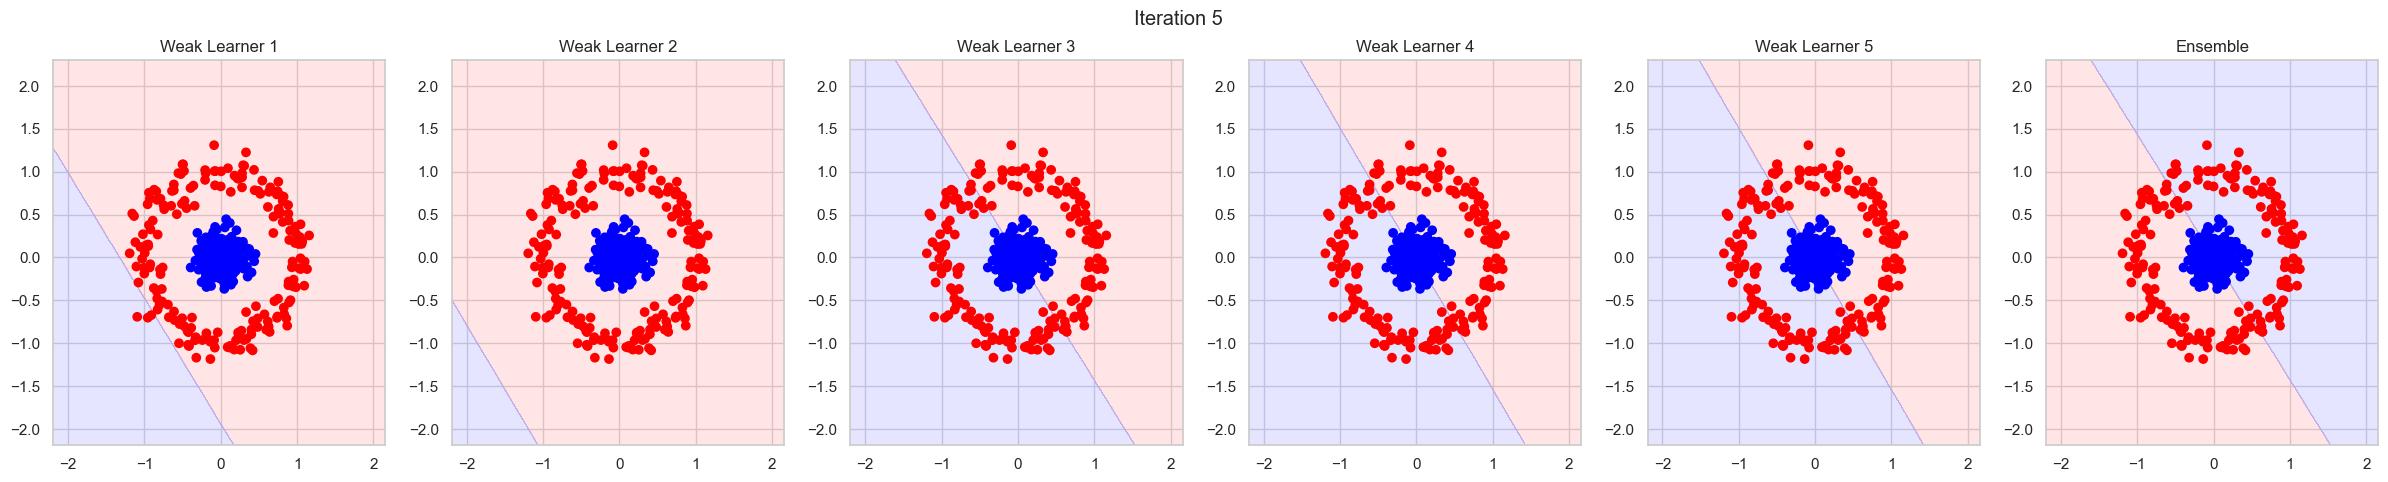

Accuracy: 0.50
Training AdaBoost with Linear SVM as weak learner


c:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\anike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of 

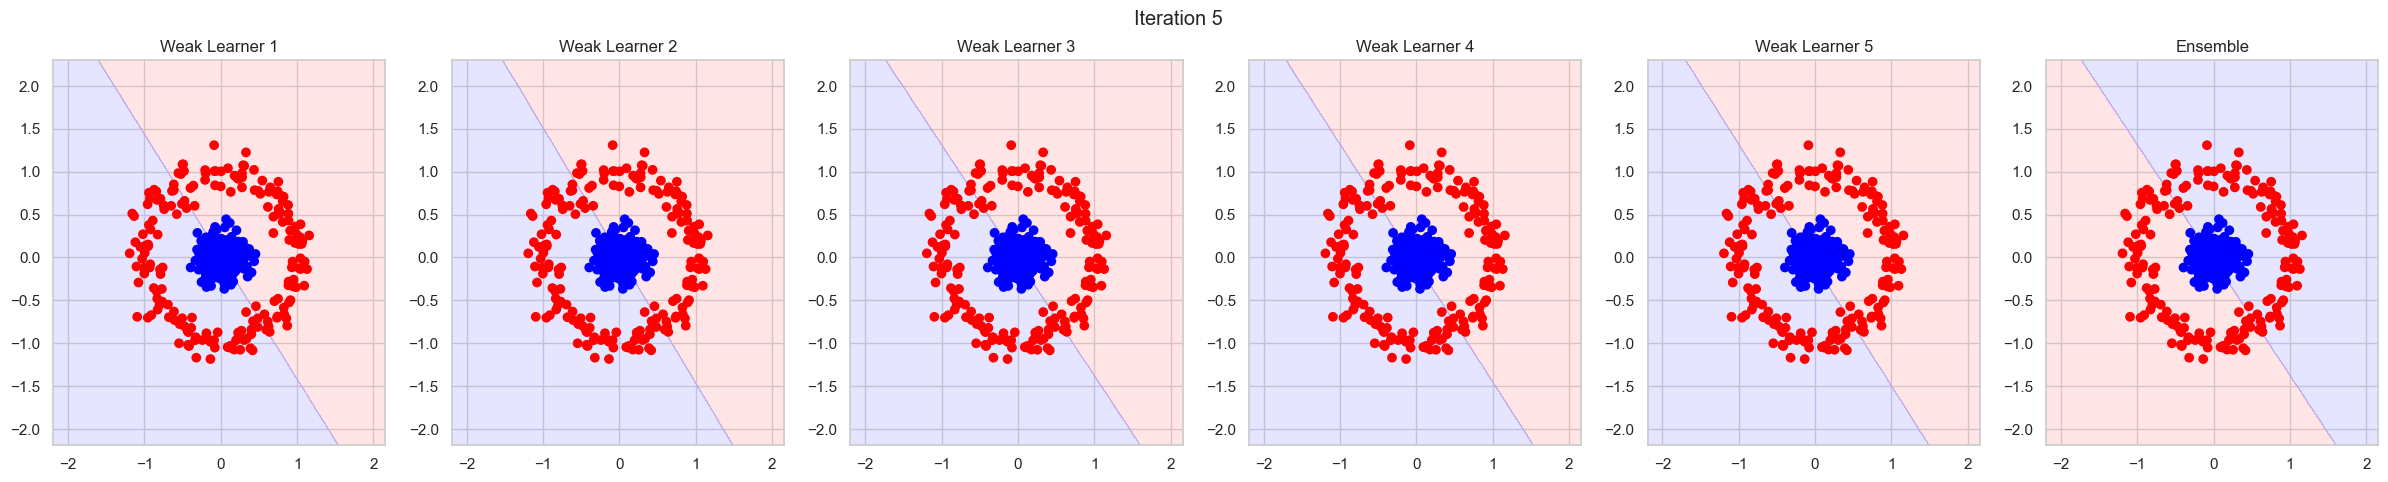

Accuracy: 0.53
Training AdaBoost with Naive Bayes as weak learner


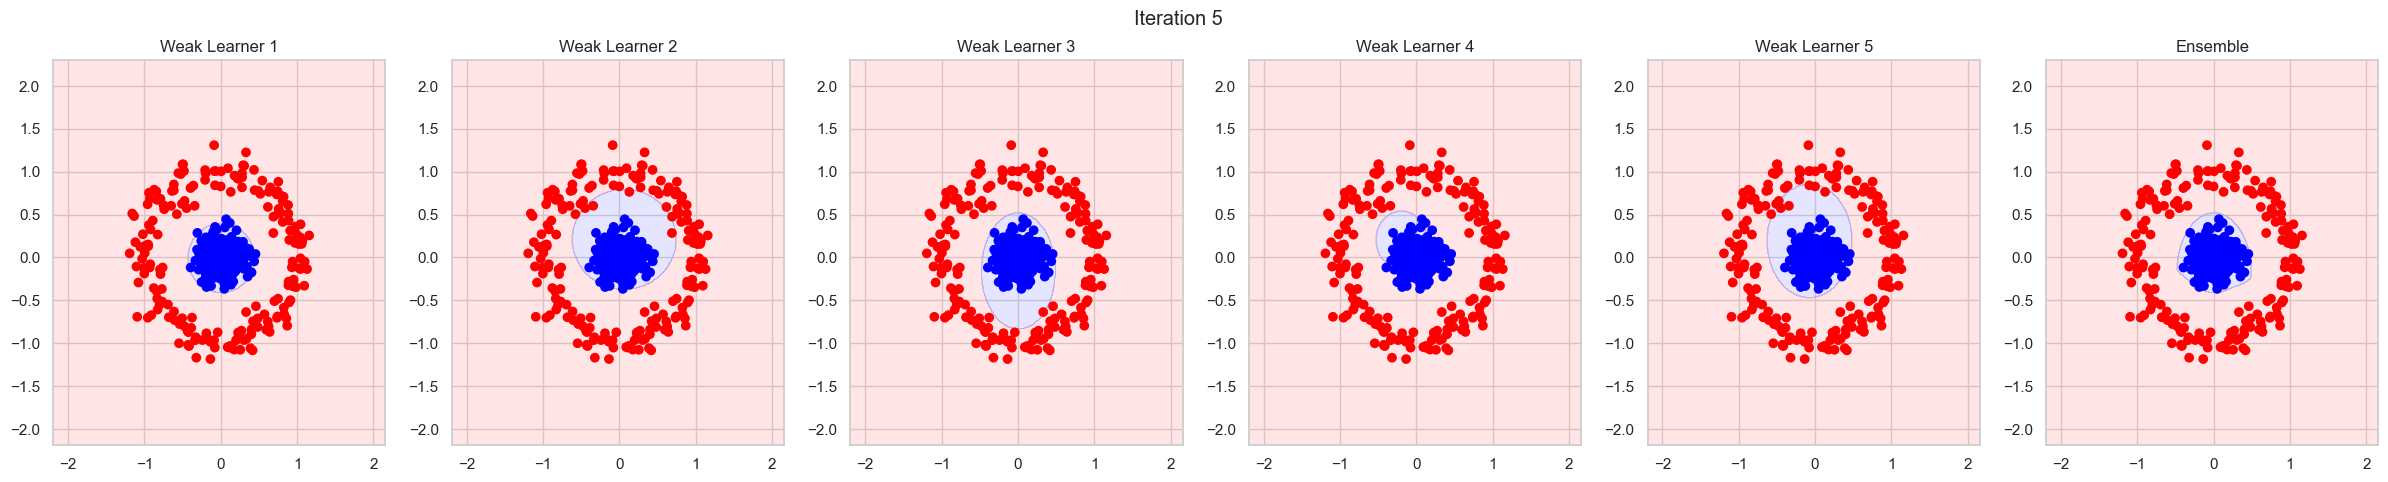

Accuracy: 1.00
Training AdaBoost with Decision Stump as weak learner


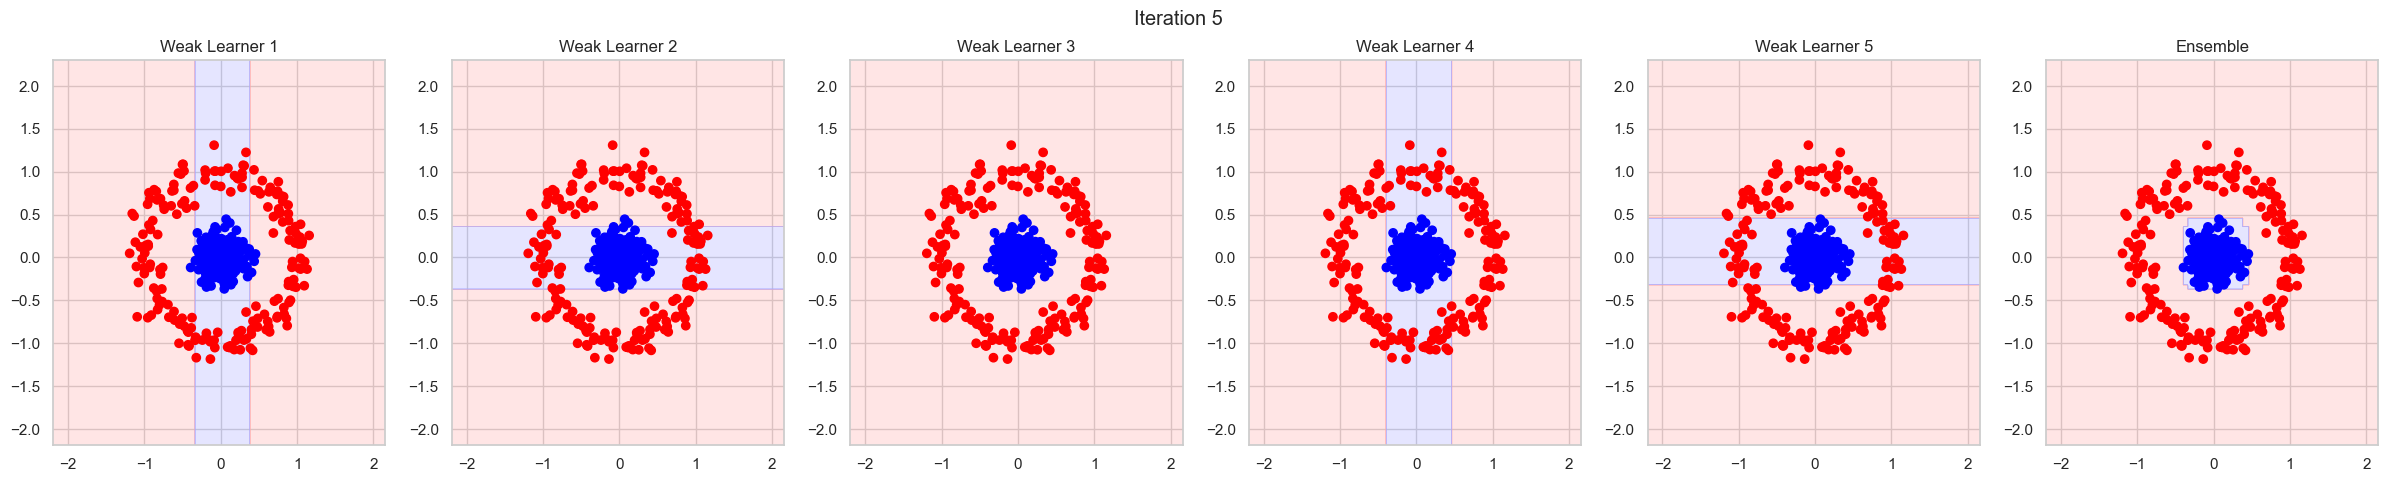

Accuracy: 0.99


In [34]:
# List of models to use as weak learners
models = [
    DecisionTreeClassifier,
    lambda: LogisticRegression(solver='liblinear'),
    lambda: LinearSVC(class_weight='balanced', max_iter=10000),
    GaussianNB,
    lambda: DecisionTreeClassifier(max_depth=2)  # Decision Stump
]

model_names = [
    "Decision Tree",
    "Logistic Regression",
    "Linear SVM",
    "Naive Bayes",
    "Decision Stump"
]

for model, name in zip(models, model_names):
    print(f"Training AdaBoost with {name} as weak learner")
    ada = Adaboost(model, n_clf=5)
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.2f}")

    # Plot decision boundaries
    ada.plot_decision_boundary(X_train, y_train, iteration=name)